# Imports

In [1]:
import numpy as np
from scipy import stats
import random

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# import library
%run lib.ipynb

# Generate data (poisson)

In [2]:
from scipy.stats import poisson

def sample_poisson(mu, size):
    return poisson.rvs(mu, loc=0, size=size)

def next_mu(min_mu=1.0, max_mu=10.0):
    mu = np.random.uniform(low=min_mu, high=max_mu, size=1)[0]
    return mu

# generate data (poisson)
def generate_data_poisson(N, M):
    H, mus = generate_data(N=N, M=M, nextConfig=next_mu, sample=sample_poisson)

    # split train/test
    # (use train_test_split so the shape of the train/test data will be the same)
    H_train, H_test, y_train, y_test = train_test_split(H, mus, test_size=0.25)
    
    return H_train, y_train, H_test, y_test

# Experiments
Learn Poisson in three different settings:

Use exact values.  
Use Log.  
Use P values, defined from the poisson thingy.  
P(k) = Log(MEASURED(k) * k!)

In [3]:
N = 10000

In [4]:
def Poisson_Experiment(X_train, y_train, X_test, y_test):

    start_time = time.time()
    dnn_model, history, y_pred, sqrt_mse = dnn_trial(X_train, y_train, X_test, y_test)
    train_time = round(time.time() - start_time)

    # debug print
    loss = np.min(history['loss'])
    val_loss = np.min(history['val_loss'])
    print(f'sqrt-mse: {sqrt_mse:.4f}', end=', ')
    #print(f'loss: {loss:.4f}', end=', ')
    #print(f'val_loss: {val_loss:.4f}', end=', ')
    print(f'train-time: {round(train_time)} sec.')

    trial_out = {
        'model': dnn_model,
        'history': history,
        'y-test': y_test,
        'y-pred': y_pred,
        'sqrt-mse': sqrt_mse,
        'train-time': train_time
    }

    return trial_out

## Experiment 1 - log vs. exact training

In [5]:
def experiment_1():
    
    trials_out = []
    
    d = {
        'M': [], 
        'm': [],
        'log-scale': [],
        'C': [], 
        'sqrt-mse': [],
        'train-time (sec.)': []
    }

    for M in [256, 512, 1024, 2048, 4096, 8192]:
        
        print()
        print(f'generating dataset (M={M}) ... ', end='')
        X_train, y_train, X_test, y_test = generate_data_poisson(N=N, M=M)
        print(f'train input.shape: {X_train.shape}')

        m = X_train.shape[1]
        
        for apply_log_scale in [True, False]:

            if apply_log_scale:
                X_train = log_scale(X_train)
                X_test = log_scale(X_test)
                print(f'training (log-scale) ... ', end='')
            else:
                print(f'training (exact-values) ... ', end='')
            
            trial_out = Poisson_Experiment(X_train, y_train, X_test, y_test)
            
            trials_out.append(trial_out)
            
            sqrt_mse = trial_out['sqrt-mse']
            train_time = trial_out['train-time']
            
            d['M'].append(M)
            d['m'].append(m)
            d['log-scale'].append(apply_log_scale)
            d['C'].append(0)
            d['sqrt-mse'].append(round(sqrt_mse, 4))
            d['train-time (sec.)'].append(f'{train_time}')
    
    df = pd.DataFrame(data=d)
    return trials_out, df

trials_out_1, df_1 = experiment_1()


generating dataset (M=256) ... train input.shape: (7500, 26)
training (log-scale) ... sqrt-mse: 0.1589, train-time: 63 sec.
training (exact-values) ... sqrt-mse: 0.1646, train-time: 70 sec.

generating dataset (M=512) ... train input.shape: (7500, 28)
training (log-scale) ... sqrt-mse: 0.1270, train-time: 47 sec.
training (exact-values) ... sqrt-mse: 0.1232, train-time: 73 sec.

generating dataset (M=1024) ... train input.shape: (7500, 27)
training (log-scale) ... sqrt-mse: 0.1039, train-time: 59 sec.
training (exact-values) ... sqrt-mse: 0.1187, train-time: 25 sec.

generating dataset (M=2048) ... train input.shape: (7500, 30)
training (log-scale) ... sqrt-mse: 0.0708, train-time: 113 sec.
training (exact-values) ... sqrt-mse: 0.0782, train-time: 37 sec.

generating dataset (M=4096) ... train input.shape: (7500, 29)
training (log-scale) ... sqrt-mse: 0.0585, train-time: 78 sec.
training (exact-values) ... sqrt-mse: 0.0543, train-time: 68 sec.

generating dataset (M=8192) ... train in

,M,m,log-scale,C,sqrt-mse,train-time (sec.)
0,256,26,True,0,0.1589,63
1,256,26,False,0,0.1646,70
2,512,28,True,0,0.1270,47
3,512,28,False,0,0.1232,73
4,1024,27,True,0,0.1039,59
5,1024,27,False,0,0.1187,25
6,2048,30,True,0,0.0708,113
7,2048,30,False,0,0.0782,37
8,4096,29,True,0,0.0585,78
9,4096,29,False,0,0.0543,68


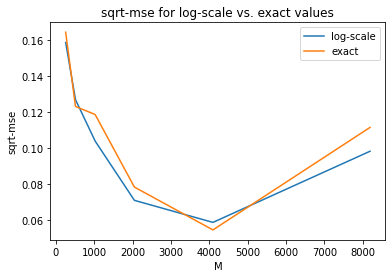

In [6]:
# plot sqrt-mse for log-scale vs. exact
def plot_log_scale_vs_exact(df):
    M_values = df.loc[df['log-scale'] == True][['M']].values
    sqrt_mse_log_scale = df.loc[df['log-scale'] == True][['sqrt-mse']].values
    sqrt_mse_exact = df.loc[df['log-scale'] == False][['sqrt-mse']].values
    _ = plt.plot(M_values, sqrt_mse_log_scale, label='log-scale')
    _ = plt.plot(M_values, sqrt_mse_exact, label='exact')
    plt.title('sqrt-mse for log-scale vs. exact values')
    plt.xlabel('M')
    plt.ylabel('sqrt-mse')
    _ = plt.legend()

plot_log_scale_vs_exact(df_1)
df_1